In [5]:
pd.options.display.float_format = '{:.3f}'.format
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [18]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date

from bokeh.io import curdoc
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, Slider, TextInput, DateRangeSlider, HelpButton, Tooltip, DataTable
from bokeh.models import NumberFormatter, TableColumn, RadioGroup, Button, CustomJS, SetValue
from bokeh.plotting import figure
from bokeh.models.dom import HTML
from bokeh.themes import Theme
from bokeh.palettes import Spectral6

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from sklearn.ensemble import RandomForestRegressor

#CONSTANTS
MAX_WIDTH_SLIDERS=600
BACKGROUND_C= "#fefffa"
DATASET_LENGTH=90
MAIN_FIG_HEIGHT=340
MIN_WIDTH=400
MODEL_OPTIONS=["SARIMAX", "RandomForestRegressor", "XGB"]


'''SYNTHETIC DATA GENERATION0.03
INCLUDING: {
seasonal_component: amplitude, frequency, shift
trend_component: slope, quadratic_curvature, CUBIC_CURVATURE
noise: standard normal distributed with mean=0, sd=1
AUTOCORELLATION : 
}
'''


# -----------------------------------------------TIME SERIES GENERATOR FUNDAMENTALS---------------------------------- #

def generate_seasonal_component(t, amplitude, frequency, shift):
    return amplitude * np.sin(2 * np.pi * frequency * t + shift* np.pi)

def generate_trend_component(t, slope, curvature_quadratic, curvature_cubic):
    return slope * t + curvature_quadratic * t**2 + curvature_cubic * t**3

def generate_autoregressive_component(t, ar_coefficients):
    ar_data = np.zeros_like(t)
    for i in range(len(ar_coefficients)):
        if i == 0:
            continue
        ar_data[i] = np.sum(ar_data[:i] * ar_coefficients[:i]) + np.random.randn()    
    return ar_data

def generate_noise(noise_level):
    return np.round(noise_level * np.random.randn(len(t)),4)

def generate_synthetic_time_series(t, amplitude, frequency, slope, shift, curvature_quadratic, curvature_cubic,
                                   ar_coefficients=None):
    seasonal_component = generate_seasonal_component(t, amplitude, frequency, shift)
    trend_component = generate_trend_component(t, slope, curvature_quadratic, curvature_cubic)
    
    if ar_coefficients is not None:
        ar_data = generate_autoregressive_component(t, ar_coefficients)
    else:
        ar_data = np.zeros_like(t)

    synthetic_data_ = seasonal_component + trend_component + ar_data
    return np.round(synthetic_data_, 4)

# SET INITIAL PARAMETERS   
t = np.linspace(0, 30, 90)
amplitude = 2.0
shift = 0
frequency = 0.1
slope = 0.1
curvature_quadratic = 0.0
curvature_cubic = 0
noise_level = 0.5
ar_coefficients = np.array([0.0, -0.0, 0.0])

# CREATE INITIAL TIME SERIES
synthetic_data = generate_synthetic_time_series(t, amplitude, frequency, slope, shift, curvature_quadratic,
                                                 curvature_cubic, ar_coefficients=None)
default_noise = generate_noise(noise_level)

synthetic_data = pd.Series(synthetic_data + default_noise)
synthetic_data.round(decimals=4)



#-----------------------------------------------BASIC BOKEH IMPLEMENTATION-------------------------------------------#

plot = figure(min_width=MIN_WIDTH, max_width=1800, height=MAIN_FIG_HEIGHT, width_policy="max", title="Synthetic time series",
              tools="pan,reset,save,wheel_zoom", margin=(0, 40, 10, 40), background_fill_color=BACKGROUND_C,
              x_range=[0, 90], y_range=[-7, 25], align="center")


source = ColumnDataSource(data=dict(time=synthetic_data.index, synthetic_data=synthetic_data.values))
plot.line('time', 'synthetic_data', source=source, line_width=3, line_alpha=0.8,  legend_label="synthetic_data")
plot.legend.location = "top_left"
plot.legend.background_fill_alpha = 0.8
plot.xaxis.axis_label = "time"
plot.yaxis.axis_label = "value"


text = TextInput(title="title", value='Synthetic Time Series fancy')
offset = Slider(title="shift", value=0.0, start=-5.0, end=5.1, step=0.1, min_width=200, align="center",
                                max_width=MAX_WIDTH_SLIDERS, width_policy="max",sizing_mode="stretch_width")
slope = Slider(title="slope", value=0.2, start=-1.0, end=1.3, step=0.1, align="center")
amplitude = Slider(title="amplitude", value=2.0, start=-6.0, end=6.0, step=0.5, align="center")
phase = Slider(title="phase", value=0.0, start=0.0, end=2, step=0.5, align="center")
freq = Slider(title="frequency", value=0.1, start=0.02, end=0.3, step=0.02, align="center")
noise = Slider(title="noise", value=0.5, start=0.0, end=2, step=0.1, align="center")
date_range_slider = DateRangeSlider(value=(date(2018, 9, 15), date(2020, 9, 15)), step=10, start=date(2016, 9, 1),
                                    end=date(2022, 4, 15), margin=(0, 30, 0, 30), min_width=200,
                                    max_width=MAX_WIDTH_SLIDERS, width_policy="max",sizing_mode="stretch_width", align="center")
train_test_split_slider = Slider(title="train_test_split", value=60, start=45, end=80, step=1, align="center")

#Components such as row() and column() elements share their sizing mode with all of their children that do not have their own explicit sizing mode.



# -----------------------------------------------CALLBACK IMPLEMENTATION--------------------------------------------#
def update_title(attrname, old, new):
    plot.title.text = text.value

def update_data(attrname, old, new):

    # Get the current slider values
    a = amplitude.value
    b = offset.value
    p = phase.value
    k = freq.value
    s = slope.value

    synthetic_data_temp = pd.Series(generate_synthetic_time_series(t, a, k, s, p, curvature_quadratic, curvature_cubic,
                                    ar_coefficients)+ default_noise)
    synthetic_data_temp.round(decimals=4)
    source.data = dict(time=synthetic_data_temp.index, synthetic_data=synthetic_data_temp.values)

def update_noise(attrname, old, new):
    global default_noise

    n = noise.value
    updated_noise = generate_noise(n)
    default_noise=updated_noise
    
    a = amplitude.value
    b = offset.value
    p = phase.value
    k = freq.value
    s = slope.value

    synthetic_data_temp = pd.Series(generate_synthetic_time_series(t, a, k, s, p, curvature_quadratic, curvature_cubic,
                                    ar_coefficients)+ updated_noise)
    source.data = dict(time=synthetic_data_temp.index, synthetic_data=synthetic_data_temp.values)
    

text.on_change('value', update_title)
noise.on_change("value", update_noise)

#for widget_ in [offset,slope, amplitude, phase, freq]:
 #   widget_.on_change('value', update_data)



# -------------------------------------MODEL IMPLEMENTATION & BOKEH TRANSFORMATION------------------------------------#
# Data Preparation & Train-Test Split

y_train_CDS = ColumnDataSource({"time":[], "value": []})
y_test_CDS = ColumnDataSource({"time":[],"value":[]})
y_pred_CDS = ColumnDataSource({"time": [],"lower_y": [], "upper_y": [],"predictions":[]})

plot_2 = figure(min_width=MIN_WIDTH, max_width=1800, height=MAIN_FIG_HEIGHT, width_policy="max", title="Synthetic time series prediction",
              tools="pan,reset,save,wheel_zoom", margin=(0, 40, 10, 40), background_fill_color=BACKGROUND_C,
                x_range=plot.x_range, y_range=[-7, 25], align="center")
plot_2.line('time', 'value', source=y_train_CDS, line_width=3, line_alpha=0.8, legend_label="Train_data")
plot_2.line('time', 'value', source=y_test_CDS, line_width=3, line_alpha=0.8, line_color="#2ca02c", legend_label="Test_data")
plot_2.line('time', 'predictions', source=y_pred_CDS, line_width=3, line_alpha=0.8, line_color="#ff7f0e", legend_label="model_prediction")
plot_2.legend.location = "top_left"
plot_2.legend.background_fill_alpha = 0.8
plot_2.xaxis.axis_label = "time"
plot_2.yaxis.axis_label = "value"




def create_model(train_df, test_df, model_selection):
    assert model_selection in MODEL_OPTIONS, f"'{model_selection}' is not a valid choise. Please choose from {MODEL_OPTIONS}."

    if model_selection == "SARIMAX":
        ARMAmodel_ = ARIMA(train_df["values"], order = (2, 2, 2))    #ARIMA(p, d, q) -> pdq account for seasonality, trend, and noise in data
        SARIMAXmodel_ = SARIMAX(train_df["values"], order = (1,1,1), seasonal_order=(1,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
        current_model = SARIMAXmodel_.fit()
        print(current_model.summary().tables[1])
        y_pred = current_model.get_forecast(len(test_df.index))
        y_pred_df = y_pred.conf_int(alpha = 0.05) 
        y_pred_df["Predictions"] = current_model.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
        y_pred_df.index = test_df["time"]
        y_pred_out = y_pred_df["Predictions"] 
        #current_model.plot_diagnostics(figsize=(16, 8))

    elif current_model =="RF_regressor":
        rf_regressor = RandomForestRegressor(n_estimators=100, max_features="sqrt", max_depth=5)
        current_model = rf_regressor.fit()
        ##TODO very much

    return current_model, y_pred_df


def update_model_(split_ind=60, model_selection="SARIMAX"):
    print('button clicked.')
    if train_test_split_slider.value is not None:
        split_ind=train_test_split_slider.value
    train_df = pd.DataFrame(data={"time": source.data["time"][0:split_ind], "values": source.data["synthetic_data"][0:split_ind]})   
    test_df = pd.DataFrame(data={"time": source.data["time"][split_ind-1:], "values": source.data["synthetic_data"][split_ind-1:]})
    
    
    ####---> GO INTO MODEL FUNC, RETURN:(train_df, test_df, pred_df)
    current_model, pred_df = create_model(train_df=train_df, test_df=test_df, model_selection=model_selection)


    y_train_CDS.data = ({"time": train_df["time"],
                        "value": train_df["values"]})
    y_test_CDS.data = ({"time": test_df["time"],
                        "value": test_df["values"]})
    y_pred_CDS.data = ({"time": pred_df.index,
                        "lower_y": pred_df.loc[:,"lower values"].values,
                        "upper_y": pred_df.loc[:,"upper values"].values,
                        "predictions": pred_df.loc[:,"Predictions"].values})
    


               
# def model_creator(d_source, split_ind=60):  #model_creator(datasource, split, model_str, plot_pal?)
#     train_df = pd.DataFrame(data={"time": d_source.data["time"][0:split_ind], "values": d_source.data["synthetic_data"][0:split_ind]})   
#     test_df = pd.DataFrame(data={"time": d_source.data["time"][split_ind-1:], "values": d_source.data["synthetic_data"][split_ind-1:]}) 
#     print(len(test_df))  


#     #####test_ds = synthetic_data[synthetic_data.index >= 60]
#     # Deterministic Model implementation & FIT

#     currentmodel = "current_model"
#     ARMAmodel_ = ARIMA(train_df["values"], order = (2, 2, 2))    #ARIMA(p, d, q) -> pdq account for seasonality, trend, and noise in data
#     SARIMAXmodel_ = SARIMAX(train_df["values"], order = (1,1,1), seasonal_order=(1,1,0,12), enforce_stationarity=False, enforce_invertibility=False)

#     current_model = SARIMAXmodel_.fit()
#     print(current_model.summary().tables[1])
#     y_pred = current_model.get_forecast(len(test_df.index))
#     y_pred_df = y_pred.conf_int(alpha = 0.05) 
#     y_pred_df["Predictions"] = current_model.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
#     y_pred_df.index = test_df["time"]
#     y_pred_out = y_pred_df["Predictions"] 
#     current_model.plot_diagnostics(figsize=(16, 8))
#     #plt.plot(y_pred_out, color='Blue', label = 'SARIMAX Predictions')
#     #plt.legend()
#     #plt.show()




# -----------------------------------------------USER EXPLANATION (HTML)----------------------------------------------#
help_slope = HelpButton(tooltip=Tooltip(content=HTML("""
the slope represents the general trend of the time series.<br /> It determines the <b>average increase</b>
in y over a period of time.<br/>More information: <a href="https://en.wikipedia.org/wiki/Slope">slope</a>!
"""), position="right"), align="center")



# -----------------------------------------------DATA TABLE IMPLEMENTATION--------------------------------------------#
columns = [
        TableColumn(field="time", title="time"),
        TableColumn(field="synthetic_data", title="value", formatter=NumberFormatter(format="0.0000")),
    ]

data_table = DataTable(source=source, columns=columns, width=400, height=250, editable=True, align="center")

#comit



# -----------------------------------------------CURRENT_DOC REFRESHMENT--------------------------------------------#
button = Button(label="Apply Model", button_type="success", align="center")
button2 = Button(label="Reset button1", button_type="success", align="center")
button2.js_on_event("button_click", SetValue(button, "label", "Apply Model"))

button.on_click(update_model_)
button.js_on_event("button_click", CustomJS(code="console.log('button: click!', this.toString())"))
button.js_on_event("button_click", SetValue(button, "label", "Model applied"))
      
     
for widget_ in [offset,slope, amplitude, phase, freq]:
    widget_.on_change('value', update_data)  
    #widget_.js_on_change("value", SetValue(button, "label", "Apply Model"))  

                   

radio_group = RadioGroup(labels=["SARIMAX", "RF_regressor", "XGB_Boost"], active=None, align="center")

def radio_handler(new):
    print('Radio button option ' + str(new) + ' selected.')
    #cd.clear()
    #cd.add_root(column(plot, radio_group))

#radio_group.on_event('button_click', radio_handler)
radio_group.js_on_event('button_click', CustomJS(code="""
    console.log('radio_group: active=' + this.origin.active, this.toString())
"""))
radio_group.js_on_event("button_click", SetValue(button, "label", "Apply XY"))

button2.js_on_event("button_click", SetValue(button, "label", radio_group.active))


# -----------------------------------------------FINALIZE LAYOUT CURRENT_DOC--------------------------------------------#


# bokeh serve --show Synth_data_app.py
# bokeh serve Synth_data_app.py --dev                        <---DEV-mode
# http://localhost:5006/Synth_data_app

curdoc().title = "Synthetic data"
slope_with_annot= row(slope, help_slope, align="center")
amplitude_with_annot = row(amplitude, help_slope, align="center")
phase_with_annot = row(phase, help_slope, align="center")
freq_with_annot = row(freq, help_slope, align="center")
noise_with_annot = row(noise, help_slope, align="center")

slider_menu_layout = column(slope_with_annot, amplitude, phase, freq, noise, sizing_mode="stretch_width")
slider_menu_layout_annot = column(slope_with_annot, amplitude_with_annot, phase_with_annot, freq_with_annot,
                                   noise_with_annot, sizing_mode="stretch_width")
model_selection_interface = column(radio_group, train_test_split_slider, button, button2, sizing_mode="stretch_width", align="center")
core_row_layout = row(slider_menu_layout, data_table, model_selection_interface, align="center")

cd = curdoc()
cd.add_root(column(plot, core_row_layout, plot_2, sizing_mode="stretch_width"))
cd.theme = Theme(filename="theme.yaml") #improving the modularity of the app and decouple the style layer from the view layer








##TODO
### Data Generation
#   |--- ADD length of data ? (Current instances: 90)
#   |--- CHANGE to datetime objects ?
#   |--- Apply Feature: Ground_level/Offset
#   |--- Apply Feature: Quadratic/Cubic Slope + Corresponding Widget

### Data Visualization
#    |--- Customizable Autocorrelation Plot (User should choose the lags) (one or span of multiple)
#    |--- distribution of data change

### Forecast Model implementation 
#   |--- 1. State of the Art Deterministic Forecast: (SARMIAX)
#   |--- 2. ML-based: Random Forest
#   |--- 3. ML-based: XGB Boost
#   |--- 4. Sophisticated ML-model: (CNN), (LSTM)

#comment 1

In [20]:
split_ind=60
train_df = pd.DataFrame(data={"time": source.data["time"][0:split_ind], "values": source.data["synthetic_data"][0:split_ind]})   
test_df = pd.DataFrame(data={"time": source.data["time"][split_ind-1:], "values": source.data["synthetic_data"][split_ind-1:]})


In [22]:
from pandas import DataFrame
from pandas import concat
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error



def time_series_lagger(data, n_in=1, n_out=1, dropnan=True):
	"""
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		pandas df: dimensionality LEN_DATA x (N_IN + N_OUT) initial:(90x(5+1))
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
		
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	
	agg = concat(cols, axis=1)
	agg.columns = names
	
	if dropnan:
		agg.dropna(inplace=True)
		
	return agg

def train_test_split(data, test_set_len):
	return data[:-test_set_len, :], data[-test_set_len:, :]



def random_forest_initial(train):
	# transform list into array if necessary
	train_ = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train_[:, :-1], train_[:, -1]
	print("trainX: \n{}".format(trainX[0:5]))
	print("trainy:\n{}".format(trainy))
	print(80*"-")
	
	current_model = RandomForestRegressor(n_estimators=300)
	current_model.fit(trainX, trainy)
	return current_model


def walk_forward_validation_historic(data, test_set_len):
	prediction_list = list()
	train_data, test_data = train_test_split(data.values, test_set_len) #receives np.array (df.values) 90x5 -> returns df 60x5, 30x5
	print(data.shape)
	print(train_data.shape)
	print(test_data.shape)
	current_model = random_forest_initial(train_data)
	for i in range(len(test_data)):
		testX, testy = test_data[i, :-1], test_data[i, -1]      #--> 1x5; 1x1 from 30x5, 30x1
		y_pred= current_model.predict([testX])
		prediction_list.append(y_pred[0])	
		print('>expected=%.1f, predicted=%.1f' % (testy, y_pred[0]))

	error = mean_absolute_error(test_data[:, -1], prediction_list)
	return error, test_data[:, -1], prediction_list



#-----#
#-----#
#-------------------------------------------------------------------------FOLLOWING FUNCTIONS IN DEVELOPMENT-------------------------#
#-----#
#-----#
def random_forest_forecast(train, testX):
	# transform list into array if necessary
	train_ = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train_[:, :-1], train_[:, -1]
	print("trainX: \n{}".format(trainX[0:5]))
	print("trainy:\n{}".format(trainy))
	print(80*"-")
	
	model = RandomForestRegressor(n_estimators=300)
	model.fit(trainX, trainy)
	# make a one-step prediction
	#print("real value: {}".format(train))
	y_pred = model.predict([testX])
	return y_pred[0]


def walk_forward_validation_online(data, test_set_len):
	"""
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		test_set_len: Number of test set observations
	Returns:
		error: 
		test_label: returns the test labels (real values) for the test sequence via 
		prediction_array: returns all prediction via python list
	"""
	prediction_list = list()
	train_data, test_data = train_test_split(data, test_set_len)
	history = [x for x in train_data]     #--> initial: 60x6 
	for i in range(len(test_data)):		  #--> initial: 30x6	
		testX, testy = test_data[i, :-1], test_data[i, -1]     #--> 1x5; 1x1 from 30x5, 30x1
		y_pred = random_forest_forecast(history, testX)		   #--> fit rf on history, evaluate on test instance		
		prediction_list.append(y_pred)						   #--> build y_pred array	
		history.append(test_data[i])						   #--> append to history	
		print('>expected=%.1f, predicted=%.1f' % (testy, y_pred))
		# estimate prediction error
	print(test_data[:, -1])
	error = mean_absolute_error(test_data[:, -1], prediction_list)
	return error, test_data[:, -1], prediction_list
#-------------------------------------------------------------------------FUNCTIONS ABOVE IN DEVELOPMENT-------------------------#

In [10]:
data_concatenated = pd.concat([train_df, test_df.iloc[1:,:]], ignore_index=True)
data_concatenated

,time,values
0,0,0.507
1,1,0.554
2,2,1.031
3,3,0.723
4,4,2.817
...,...,...
85,85,1.789
86,86,1.537
87,87,1.851
88,88,0.652


In [16]:
data_concatenated
tsl = time_series_lagger(data_concatenated.loc[:,"values"].to_list(), n_in=5, n_out=1)
tsl

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
5,0.507,0.554,1.031,0.723,2.817,1.457
6,0.554,1.031,0.723,2.817,1.457,2.492
7,1.031,0.723,2.817,1.457,2.492,2.900
8,0.723,2.817,1.457,2.492,2.900,2.529
9,2.817,1.457,2.492,2.900,2.529,1.762
...,...,...,...,...,...,...
85,1.433,0.293,0.369,0.187,0.662,1.789
86,0.293,0.369,0.187,0.662,1.789,1.537
87,0.369,0.187,0.662,1.789,1.537,1.851
88,0.187,0.662,1.789,1.537,1.851,0.652


(85, 6)
(55, 6)
(30, 6)
trainX: 
[[ 0.507  0.554  1.031  0.723  2.817]
 [ 0.554  1.031  0.723  2.817  1.457]
 [ 1.031  0.723  2.817  1.457  2.492]
 [ 0.723  2.817  1.457  2.492  2.900]
 [ 2.817  1.457  2.492  2.900  2.529]]
trainy:
[ 1.457  2.492  2.900  2.529  1.762  2.234  1.709  1.771  0.594  1.285
  0.321  0.085 -0.728  0.325 -1.309 -1.389 -1.019 -1.463 -0.355 -0.943
  0.391 -0.496 -0.703  0.624  0.820  0.652  1.710  1.635  2.344  3.049
  3.392  3.895  3.369  3.526  2.823  3.619  2.919  2.659  0.693  1.527
  2.004  0.374  0.818 -0.384 -0.203 -1.043 -0.300 -0.116 -1.220  0.101
 -0.187 -0.001  0.616  1.611  1.874]
--------------------------------------------------------------------------------
[-0.187 -0.001  0.616  1.611  1.874]
2.0932
>expected=2.1, predicted=1.8
[-0.001  0.616  1.611  1.874  2.093]
2.3754
>expected=2.4, predicted=2.0
[ 0.616  1.611  1.874  2.093  2.375]
3.2546
>expected=3.3, predicted=2.3
[ 1.611  1.874  2.093  2.375  3.255]
4.1389000000000005
>expected=4.1, predi

/var/folders/bj/qcw9vb7x48j_hnyzlrj_pqtr0000gn/T/ipykernel_32017/3414401098.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('>expected=%.1f, predicted=%.1f' % (testy, y_pred))
/var/folders/bj/qcw9vb7x48j_hnyzlrj_pqtr0000gn/T/ipykernel_32017/3414401098.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('>expected=%.1f, predicted=%.1f' % (testy, y_pred))
/var/folders/bj/qcw9vb7x48j_hnyzlrj_pqtr0000gn/T/ipykernel_32017/3414401098.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this oper

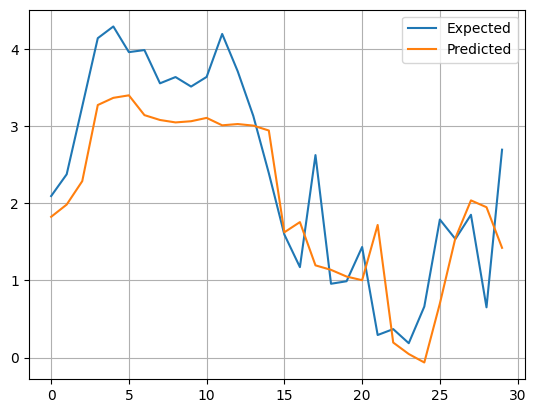

In [23]:
mae, y, y_pred = walk_forward_validation_historic(tsl, 30)
print('MAE: %.3f' % mae)
# plot expected vs predicted
plt.plot(y, label='Expected')
plt.plot(y_pred, label='Predicted')
plt.grid()
plt.legend()
plt.show()

In [33]:
#from dataframe_lagger import time_series_lagger, random_forest_forecast

lagged_df = time_series_lagger(train_df["values"].to_list(), n_in=5, n_out=1)
prediction = random_forest_forecast(lagged_df.loc[0:50,:], lagged_df.iloc[51,:-1])
print("test: \n{}".format(lagged_df.iloc[51:52,:-1]))
print("\nreal value:\n{}".format(lagged_df.iloc[51,-1]))
print("\nprediction:\n{}".format(prediction))

trainX: 
[[0.9667 0.3614 0.2559 1.6325 1.4926]
 [0.3614 0.2559 1.6325 1.4926 1.9788]
 [0.2559 1.6325 1.4926 1.9788 2.2842]
 [1.6325 1.4926 1.9788 2.2842 1.7365]
 [1.4926 1.9788 2.2842 1.7365 3.2905]]
trainy:
[ 1.9788  2.2842  1.7365  3.2905  1.7355  1.9399  1.8435  1.3926  1.1542
 -0.3298 -0.1535 -0.2733 -0.197  -0.4015 -1.1626 -1.6665 -1.4322 -2.1494
 -0.9018 -0.8905 -0.2035  0.1816  0.4342 -0.2049 -0.0166  0.3001  1.7578
  1.311   2.649   3.1314  2.9007  3.0557  3.6239  2.6702  3.2527  3.437
  1.9423  2.3035  1.3464  1.7998  1.3595  1.6745  0.2882  0.6448 -0.4343
  0.6209]
--------------------------------------------------------------------------------
test: 
    var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)
56    -0.1004    -0.2749    -1.0492     -0.362    -0.1366

real value:
0.21459999999999996

prediction:
-0.004889333333333326


In [28]:
lagged_df

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
5,0.9667,0.3614,0.2559,1.6325,1.4926,1.9788
6,0.3614,0.2559,1.6325,1.4926,1.9788,2.2842
7,0.2559,1.6325,1.4926,1.9788,2.2842,1.7365
8,1.6325,1.4926,1.9788,2.2842,1.7365,3.2905
9,1.4926,1.9788,2.2842,1.7365,3.2905,1.7355
10,1.9788,2.2842,1.7365,3.2905,1.7355,1.9399
11,2.2842,1.7365,3.2905,1.7355,1.9399,1.8435
12,1.7365,3.2905,1.7355,1.9399,1.8435,1.3926
13,3.2905,1.7355,1.9399,1.8435,1.3926,1.1542
14,1.7355,1.9399,1.8435,1.3926,1.1542,-0.3298


In [4]:
train_df.iloc[51,:]

time      51.0000
values    -0.1004
Name: 51, dtype: float64

In [5]:
train_ds

NameError: name 'train_ds' is not defined

In [ ]:
import pandas as pd
train_idx = source.data["time"][0:60]
train_val = source.data["synthetic_data"][0:60]

train_ds_new = pd.DataFrame(data={"time": source.data["time"][0:60], "values": source.data["synthetic_data"][0:60]})
#train_ds_new.set_index("time", inplace=True) # as soon as time is a datetime object it should not be the index anymore
train_ds_new["values"]

2    0.2186
3    1.0092
Name: values, dtype: float64

In [ ]:
y_pred_df["time"]=y_pred_df.index
y_pred_df

,lower y,upper y,Predictions,time
60,0.305594,3.752637,2.029115,60
61,-0.574649,4.199875,1.812613,61
62,-1.299387,4.439553,1.570083,62
63,-1.195135,5.320356,2.062611,63
64,-1.911783,5.262065,1.675141,64
65,-2.252536,5.497797,1.622631,65
66,-2.297245,5.969439,1.836097,66
67,-3.138073,5.598979,1.230453,67
68,-3.128617,6.042581,1.456982,68
69,-4.510655,5.065472,0.277409,69


In [ ]:
print(y_pred_df.columns)
y_pred_CDS = ColumnDataSource({"time": y_pred_df.index,
                               "lower_y": y_pred_df.loc[:,"lower y"].values,
                               "upper_y": y_pred_df.loc[:,"upper y"].values,
                               "predictions": y_pred_df.loc[:,"Predictions"].values})
y_pred_CDS.data

Index(['lower y', 'upper y', 'Predictions', 'time'], dtype='object')


{'time': Index([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
        78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       dtype='int64'),
 'lower_y': array([  0.30559382,  -0.5746488 ,  -1.29938715,  -1.19513499,
         -1.91178348,  -2.25253621,  -2.29724471,  -3.1380734 ,
         -3.12861673,  -4.5106546 ,  -4.5306523 ,  -4.5117397 ,
         -5.24020796,  -5.30640696,  -6.50556024,  -6.83069565,
         -6.2243087 ,  -6.38457913,  -6.53327456,  -7.18338995,
         -6.5878404 ,  -7.98214982,  -7.48802405,  -7.22043829,
         -7.62743957,  -8.19331914,  -9.13701998,  -9.27062112,
         -9.63203415, -10.02390417]),
 'upper_y': array([ 3.75263655,  4.19987525,  4.43955259,  5.32035609,  5.26206486,
         5.49779722,  5.96943886,  5.59897942,  6.04258114,  5.06547201,
         5.42637961,  5.80611773,  5.78498152,  6.3616784 ,  5.7548635 ,
         5.98142088,  7.10616789,  7.43645928,  7.75480347,  7.55156662,
         8.57651484,  7.59629074